In [1]:
%pylab inline
from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm
from helpers.dataTransfer import saveFullDataToRemote

Populating the interactive namespace from numpy and matplotlib


# Data Saving Info

In [2]:
remotePath = "C:/Users/hatla/Downloads"
sampleName = "Q1"

# Configuring the channels

The data in this notebook was taken with a wiring diagram similar to the above. The QICK has eight RF DACs which can be configured in multiple ways. Using the QICK, two RF DACs are needed to control the qubit and its readout resonator, respectively. Also, the qubit control pulses (< 6 GHz) were directly synthesized without the use of an analog mixer. Note that the QICK RF board was not used for these measurements, only the ZCU111 evaluation board plus the analog components specified in the diagram.

In [3]:
# Load bitstream with custom overlay
soc = QickSoc()
soc.set_nyquist(ch=7,nqz=1) #Readout_I
soc.set_nyquist(ch=6,nqz=1) #Readout_Q
soc.set_nyquist(ch=3,nqz=2) #Qubit
hw_cfg={"res_ch_I":6,
        "res_ch_Q":7,
        "qubit_ch":3,
       }

# TOF Measurement

Measures the "time of flight" of the measurement pulse. The time of flight is the time at which the measurement pulse appears in the ADC buffer. We only want to start capturing data from this point in time onwards. We store this time of flight in the parameter <code> readout_cfg["adc_trig_offset"] </code>.

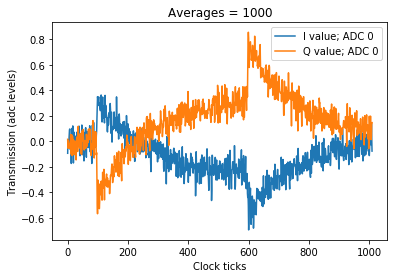

In [9]:
class LoopbackProgram(AveragerProgram):
    def initialize(self):
        cfg=self.cfg   
        cfg["adc_lengths"]=[cfg["readout_length"]]*2          #add length of adc acquisition to config
        cfg["adc_freqs"]=[soc.adcfreq(cfg["res_freq"])]*2   #add frequency of adc dds to config
        
        self.res_gain_I = int(cfg["res_gain"])
        self.res_gain_Q = int(cfg["res_gain"] * cfg["IQScale"])
        self.res_phase_I = deg2reg(cfg["res_phase"])
        self.res_phase_Q = deg2reg(cfg["skewPhase"]+cfg["res_phase"])
        self.res_length = cfg["res_length"]
        self.res_freq = soc.freq2reg(soc.adcfreq(cfg["res_freq"]))  # convert frequency to dac frequency (ensuring it is an available adc frequency)
        
#         self.qubit_freq=soc.freq2reg(soc.adcfreq(cfg["qubit_freq"]))  # convert frequency to dac frequency (ensuring it is an available adc frequency)
#         self.qubit_gain = int(cfg["qubit_gain"])
        
        
        self.add_pulse(ch=cfg["res_ch_I"], name="measure", style="const", length=self.res_length)  #add a constant pulse to the pulse library
        self.add_pulse(ch=cfg["res_ch_Q"], name="measure", style="const", length=self.res_length)  #add a constant pulse to the pulse library
        
        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):
        cfg=self.cfg   
        t0 = 500
        self.pulse(ch=cfg["res_ch_I"], name="measure", freq=self.res_freq, phase=self.res_phase_I, gain=self.res_gain_I, length=self.res_length, mode=0, t=t0, play=True) 
        self.pulse(ch=cfg["res_ch_Q"], name="measure", freq=self.res_freq, phase=self.res_phase_Q, gain=self.res_gain_Q, length=self.res_length, mode=0, t=t0, play=True) 
        self.trigger_adc(adc1=1, adc2=1,adc_trig_offset=cfg["adc_trig_offset"], t=t0, PMOD_states=[0,0,0,0])  # trigger the adc acquisition
        self.marker(t=t0+30, t1=0, t2=1, short=False)
        self.marker(t=t0+30+self.res_length, t1=0, t2=0, short=False)
        
        self.sync_all(soc.us2cycles(self.cfg["relax_delay"]))  # sync all channels

readout_cfg={
    "reps":1, # --Fixed
    "adc_trig_offset": 170, # [clock ticks]
    "readout_length":1010, # [clock ticks]
    
    "res_freq": 90, # [MHz]
    "res_gain": 3000, # [DAC units]
    "res_length": 500, # [clock ticks]
    "res_phase" : 0, # [deg]
    "skewPhase":83, # [Degrees]
    "IQScale":1.03,
    
    "soft_avgs": 1000,
    "relax_delay": 10 # [us]
}

config={**hw_cfg, **readout_cfg}
prog =LoopbackProgram(config)
adc1, adc2 = prog.acquire_decimated(soc, load_pulses=True, progress=True, debug=False)

# Plot results.
subplot(111, title=f"Averages = {config['soft_avgs']}", xlabel="Clock ticks", ylabel="Transmission (adc levels)")
plot(adc1[0], label="I value; ADC 0")
plot(adc1[1], label="Q value; ADC 0")
legend()

# IQ Histogram

In [10]:
readout_cfg={
    "reps":20000, # --Fixed
    "adc_trig_offset": 170, # [clock ticks]
    "readout_length":1010, # [clock ticks]
    
    "res_freq": 90, # [MHz]
    "res_gain": 3000, # [DAC units]
    "res_length": 500, # [clock ticks]
    "res_phase" : 0, # [deg]
    "skewPhase":83, # [Degrees]
    "IQScale":1.03,
    
    "rounds": 1,
    "relax_delay": 20 #[us]
}

config={**hw_cfg, **readout_cfg}
prog =LoopbackProgram(config)
avgi, avgq = prog.acquire(soc, load_pulses=True,progress=True, debug=False)



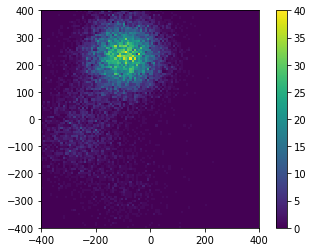

In [11]:
# Plot results.
fig, ax = plt.subplots()
hist=ax.hist2d(prog.di_buf[0],prog.dq_buf[0], bins=101, range=[[-400,400], [-400,400]])
ax.set_aspect(1)
fig.colorbar(hist[3])

# Pulse Probe (qubit) spectroscopy

Measures the qubit frequency f_ge. We store this parameter here: <code> qubit_cfg["f_ge"] </code>.

This program uses the RAveragerProgram class, which allows you to sweep a parameter directly on the processor rather than in a Python loop as in the above resonator spectroscopy example. Because the whole sweep is done on the processor there is less downtime (especially for fast experiments).

In [40]:
class PulseProbeSpectroscopyProgram(RAveragerProgram):
    def initialize(self):
        cfg=self.cfg
        self.cfg["adc_lengths"]=[self.cfg["readout_length"]]*2   #copy over adc acquisition parameters
        self.cfg["adc_freqs"]=[soc.adcfreq(cfg["res_freq"])]*2
        
        self.res_gain_I = int(cfg["res_gain"])
        self.res_gain_Q = int(cfg["res_gain"] * cfg["IQScale"])
        self.res_phase_I = deg2reg(cfg["res_phase"])
        self.res_phase_Q = deg2reg(cfg["skewPhase"]+cfg["res_phase"])
        self.res_length = cfg["res_length"]
        self.res_freq = soc.freq2reg(soc.adcfreq(cfg["res_freq"]))  # convert frequency to dac frequency (ensuring it is an available adc frequency)

        self.qubit_gain = int(cfg["qubit_gain"])
   
        
        self.q_rp=self.ch_page(self.cfg["qubit_ch"])     # get register page for qubit_ch
        self.r_freq=self.sreg(cfg["qubit_ch"], "freq")   # get frequency register for qubit_ch    

        
        # add qubit and readout pulses to respective channels
        self.add_pulse(ch=self.cfg["qubit_ch"], name="qubit",style="const", length=self.cfg["probe_length"])
        self.add_pulse(ch=cfg["res_ch_I"], name="measure", style="const", length=self.res_length)  #add a constant pulse to the pulse library
        self.add_pulse(ch=cfg["res_ch_Q"], name="measure", style="const", length=self.res_length)  #add a constant pulse to the pulse library

        self.f_start = soc.freq2reg(cfg["start"])  # get start/step frequencies
        self.f_step = soc.freq2reg(cfg["step"])
        
        # pre-initialize pulses
        self.pulse(ch=cfg["qubit_ch"], name="qubit", phase=0, freq=self.f_start, gain=cfg["qubit_gain"], play=False)
    
        self.sync_all(soc.us2cycles(1))
    
    def body(self):
        cfg=self.cfg
        self.pulse(ch=self.cfg["qubit_ch"], play=True)  #play probe pulse        
#         self.marker(t=30, t1=1, t2=1, short=False)
#         self.marker(t=30+self.cfg["probe_length"], t1=0, t2=0, short=False)
        self.sync_all(soc.us2cycles(0.05)) # align channels and wait 50ns
        t0=0
        self.pulse(ch=cfg["res_ch_I"], name="measure", freq=self.res_freq, phase=self.res_phase_I, gain=self.res_gain_I, length=self.res_length, mode=0, t=t0, play=True) 
        self.pulse(ch=cfg["res_ch_Q"], name="measure", freq=self.res_freq, phase=self.res_phase_Q, gain=self.res_gain_Q, length=self.res_length, mode=0, t=t0, play=True) 
        self.trigger_adc(adc1=1, adc2=1,adc_trig_offset=cfg["adc_trig_offset"], t=t0, PMOD_states=[0,0,0,0])  # trigger the adc acquisition
#         self.marker(t=t0+30, t1=0, t2=1, short=False)
#         self.marker(t=t0+30+self.res_length, t1=0, t2=0, short=False)
        self.sync_all(soc.us2cycles(self.cfg["relax_delay"]))  # wait for qubit to relax
    
    def update(self):
        self.mathi(self.q_rp, self.r_freq, self.r_freq, '+', self.f_step) # update frequency list index

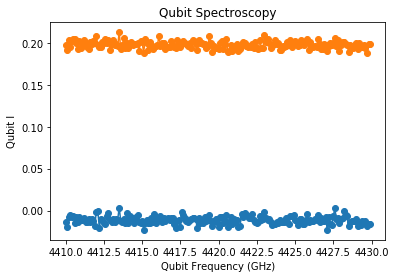

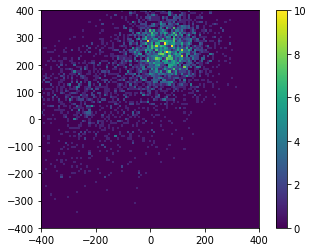

In [45]:
expt_cfg={"start":4410, 
          "step":0.1, 
          "expts":200, 
          "reps": 20,
          "rounds":50,
          "probe_length":soc.us2cycles(2), 
          "qubit_gain":10000,
          "relax_delay": 200 #[us]
         }


# qubit_cfg={
#     "sigma": soc.us2cycles(0.025),
#     "pi_gain": 11500,
#     "pi2_gain":11500//2, 
#     "f_ge":4743.041802067813,
#     "relax_delay":500
# }

config={**hw_cfg,**readout_cfg,**expt_cfg} #combine configs

qspec=PulseProbeSpectroscopyProgram(cfg=config)
expt_pts, avgi, avgq = qspec.acquire(soc, load_pulses=True,progress=True, debug=False)

subplot(111,title="Qubit Spectroscopy", xlabel="Qubit Frequency (GHz)", ylabel="Qubit I")
plot(expt_pts, avgi[0][0],'o-')
plot(expt_pts, avgq[0][0],'o-')

fig, ax = plt.subplots()
hist=ax.hist2d(qspec.di_buf[0],qspec.dq_buf[0], bins=101, range=[[-400,400], [-400,400]])
ax.set_aspect(1)
fig.colorbar(hist[3])

In [44]:
prog


// Program

        synci 200;
        regwi 0, $15, 0;
        regwi 0, $14, 19999;
LOOP_J: regwi 2, $23, 62914560;                 //freq = 62914560
        regwi 2, $24, 0;                        //phase = 0
        regwi 2, $26, 4000;                     //gain = 4000
        regwi 2, $28, 500;                      //t = 500
        regwi 2, $27, 590224;                   //stdysel | mode | outsel = 0b01001 | length = 400 
        regwi 2, $28, 500;                      //t = 500
        set 6, 2, $23, $24, $25, $26, $27, $28; //ch = 6, out = $23,$24,$25,$26,$27 @t = $28
        regwi 3, $16, 62914560;                 //freq = 62914560
        regwi 3, $17, 990228571;                //phase = 990228571
        regwi 3, $19, 4120;                     //gain = 4120
        regwi 3, $21, 500;                      //t = 500
        regwi 3, $20, 590224;                   //stdysel | mode | outsel = 0b01001 | length = 400 
        regwi 3, $21, 500;                      //t = 500
     

# Length Rabi

Measures Rabi oscillations by sweeping over the duration of the qubit drive pulse. This is a preliminary measurement to prove that we see Rabi oscillations. This measurement is followed up by the Amplitude Rabi experiment below.

In [11]:
class LengthRabiProgram(AveragerProgram):
    def initialize(self):
        cfg=self.cfg

        
        cfg["adc_lengths"]=[cfg["readout_length"]]*2
        cfg["adc_freqs"]=[adcfreq(cfg["f_res"])]*2
        
        self.add_pulse(ch=cfg["qubit_ch"], name="qubit",style="const", length=cfg["pulse_length"])
        self.add_pulse(ch=cfg["res_ch"], name="measure",style="const", length=cfg["readout_length"])

        self.pulse(ch=cfg["qubit_ch"], name="qubit", phase=0, freq=freq2reg(cfg["f_ge"]), gain=cfg["qubit_gain"], play=False)
        self.pulse(ch=cfg["res_ch"], name="measure", freq=freq2reg(adcfreq(cfg["f_res"])), phase=cfg['res_phase'], gain=cfg["res_gain"], play=False)
               
        self.synci(200)
        
    def body(self):
        cfg=self.cfg

        self.pulse(ch=cfg["qubit_ch"], play=True)
        self.sync_all(us2cycles(0.05))
        self.trigger_adc(adc1=1, adc2=1)
        self.pulse(ch=cfg["res_ch"], play=True)
        self.sync_all(us2cycles(self.cfg["relax_delay"]))

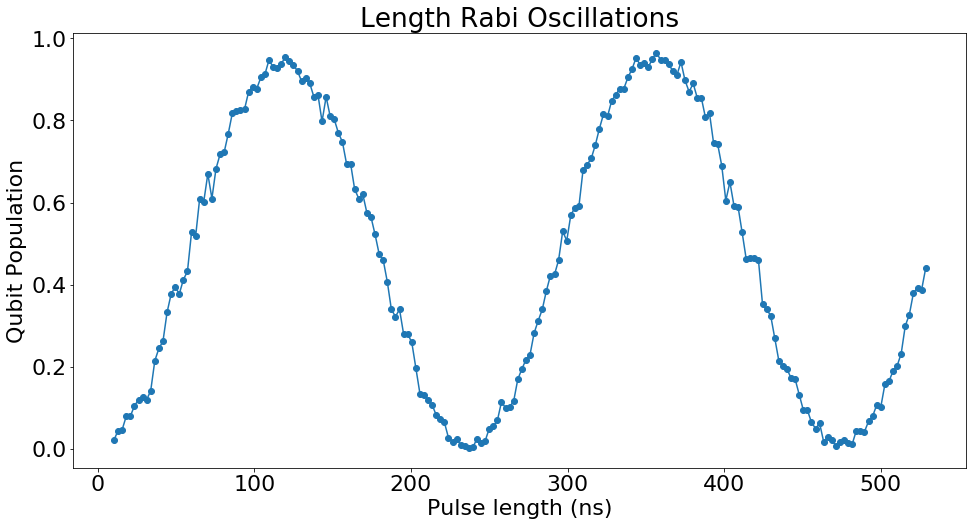

In [12]:
expt_cfg={
       "qubit_gain":2000,
        "start":4, "step":1, "expts":200, "reps": 400,
       }
config={**hw_cfg,**readout_cfg,**qubit_cfg,**expt_cfg} #combine configs
expt_pts=[expt_cfg["start"] + ii*expt_cfg["step"] for ii in range(expt_cfg["expts"])]


results=[]
for length in tqdm(expt_pts):
    config["pulse_length"]=length

    rabi=LengthRabiProgram(config)
    avgi,avgq = rabi.acquire(soc, threshold=readout_cfg["threshold"], load_pulses=True, progress=False,debug=False)
    results.append(avgi[0][0])
    
subplot(111, title="Length Rabi Oscillations", xlabel="Pulse length (ns)", ylabel="Qubit Population")
plot(cycles2us(np.array(expt_pts))*1000,results,'o-');

# Amplitude Rabi

Measures Rabi oscillations by sweeping over the amplitude of the qubit drive pulse, which is an $\approx$ 100 ns ($\sigma$ $\approx$ 25 ns) long Gaussian pulse. We measure the $\pi$ and $\pi$/2 pulse amplitudes which are used in subsequent experiments to control the qubit. We store these parameters here: <code> qubit_cfg["pi_gain"] </code> and <code> qubit_cfg["pi2_gain"] </code>

In [13]:
class AmplitudeRabiProgram(RAveragerProgram):

    def initialize(self):
        cfg=self.cfg
        
        self.q_rp=self.ch_page(self.cfg["qubit_ch"])     # get register page for qubit_ch
        self.r_gain=self.sreg(cfg["qubit_ch"], "gain")   # get gain register for qubit_ch    
        
        f_res=freq2reg(adcfreq(cfg["f_res"]))            # conver f_res to dac register value
        f_ge=freq2reg(cfg["f_ge"])
        
        self.cfg["adc_lengths"]=[self.cfg["readout_length"]]*2   #copy over adc acquisition parameters
        self.cfg["adc_freqs"]=[adcfreq(cfg["f_res"])]*2
        
        # add qubit and readout pulses to respective channels
        self.add_pulse(ch=self.cfg["qubit_ch"], name="qubit", style="arb", 
                       idata=gauss(mu=cfg["sigma"]*16*4/2,si=cfg["sigma"]*16,length=4*cfg["sigma"]*16,maxv=2**15-1), 
                       qdata=0*gauss(mu=cfg["sigma"]*16*4/2,si=cfg["sigma"]*16,length=4*cfg["sigma"]*16,maxv=2**15-1))
        self.add_pulse(ch=self.cfg["res_ch"], name="measure", style="const", length=self.cfg["readout_length"])
        
        # pre-initialize pulses
        self.pulse(ch=cfg["qubit_ch"], name="qubit", phase =0, freq=f_ge, gain=cfg["start"], play=False)
        self.pulse(ch=cfg["res_ch"], name="measure", freq=f_res, phase=cfg["res_phase"], gain=cfg["res_gain"], play=False)
    
        self.sync_all(us2cycles(500))
    
    def body(self):
        
        self.pulse(ch=self.cfg["qubit_ch"], play=True, phase=deg2reg(90))  #play probe pulse
        self.sync_all(us2cycles(0.05)) # align channels and wait 50ns
        self.trigger_adc(adc1=1, adc2=1, adc_trig_offset=self.cfg["adc_trig_offset"])  #trigger measurement
        self.pulse(ch=self.cfg["res_ch"], name="measure", play=True) # play measurement pulse

        self.sync_all(us2cycles(self.cfg["relax_delay"]))  # wait for qubit to relax
    
    def update(self):
        self.mathi(self.q_rp, self.r_gain, self.r_gain, '+', self.cfg["step"]) # update gain of the Gaussian pi pulse

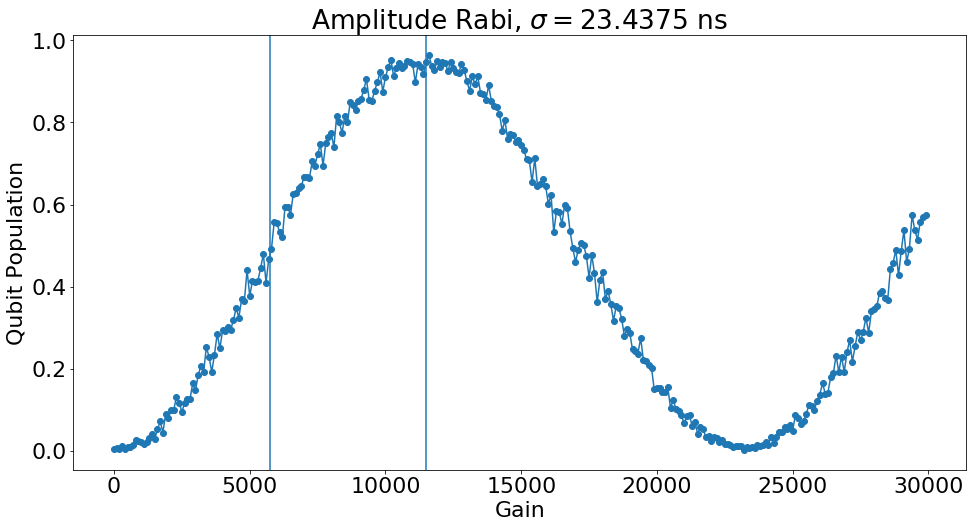

In [14]:
expt_cfg={
        "start":0, "step":100, "expts":300, "reps": 400
       }
config={**hw_cfg,**readout_cfg,**qubit_cfg,**expt_cfg} #combine configs

rabi=AmplitudeRabiProgram(cfg=config)
x_pts, avgi, avgq  = rabi.acquire(soc,threshold=readout_cfg["threshold"], load_pulses=True,progress=True, debug=False)

subplot(111, title= f"Amplitude Rabi, $\sigma={cycles2us(config['sigma'])*1000}$ ns", xlabel="Gain", ylabel="Qubit Population" )
plot(x_pts,avgi[0][0],'o-')

axvline(qubit_cfg["pi_gain"])
axvline(qubit_cfg["pi2_gain"]);

# T1 

Measures the qubit T1 characteristic decay time by preparing the qubit in its excited state with a $\pi$ pulse followed by a variable delay ($\tau$) before measuring the qubit's state. This exponential decay curve can be fitted in post-processing to obtain the qubit T1 time.

In [15]:
class T1Program(RAveragerProgram):
    def __init__(self,cfg):
        AveragerProgram.__init__(self,cfg)       
        
    def initialize(self):
        cfg=self.cfg
        
        
        self.q_rp=self.ch_page(self.cfg["qubit_ch"])     # get register page for qubit_ch
        self.r_wait = 3
        self.regwi(self.q_rp, self.r_wait, cfg["start"])
               
        self.cfg["adc_lengths"]=[self.cfg["readout_length"]]*2   #copy over adc acquisition parameters
        self.cfg["adc_freqs"]=[adcfreq(cfg["f_res"])]*2
        
        # add qubit and readout pulses to respective channels
        self.add_pulse(ch=self.cfg["qubit_ch"], name="qubit",style="arb", idata=gauss(mu=cfg["sigma"]*16*4/2,si=cfg["sigma"]*16,length=4*cfg["sigma"]*16,maxv=2**15-1))
        self.add_pulse(ch=self.cfg["res_ch"], name="measure",style="const", length=self.cfg["readout_length"])
               
        # pre-initialize pulses
        self.pulse(ch=cfg["qubit_ch"], name="qubit", phase =0, freq=freq2reg(cfg["f_ge"]), gain=cfg["pi_gain"], play=False)
        self.pulse(ch=cfg["res_ch"], name="measure", freq=freq2reg(adcfreq(cfg["f_res"])), phase=cfg['res_phase'], gain=cfg["res_gain"], play=False)
    
        self.sync_all(us2cycles(500))
    
    def body(self):
        
        self.pulse(ch=self.cfg["qubit_ch"], play=True)  #play probe pulse
        self.sync_all()
        self.sync(self.q_rp,self.r_wait)
        self.trigger_adc(adc1=1, adc2=1, adc_trig_offset=self.cfg["adc_trig_offset"])  #trigger measurement
        self.pulse(ch=self.cfg["res_ch"], name="measure", play=True) # play measurement pulse

        self.sync_all(us2cycles(self.cfg["relax_delay"]))  # wait for qubit to relax
    
    def update(self):
        self.mathi(self.q_rp, self.r_wait, self.r_wait, '+', us2cycles(self.cfg["step"])) # update frequency list index

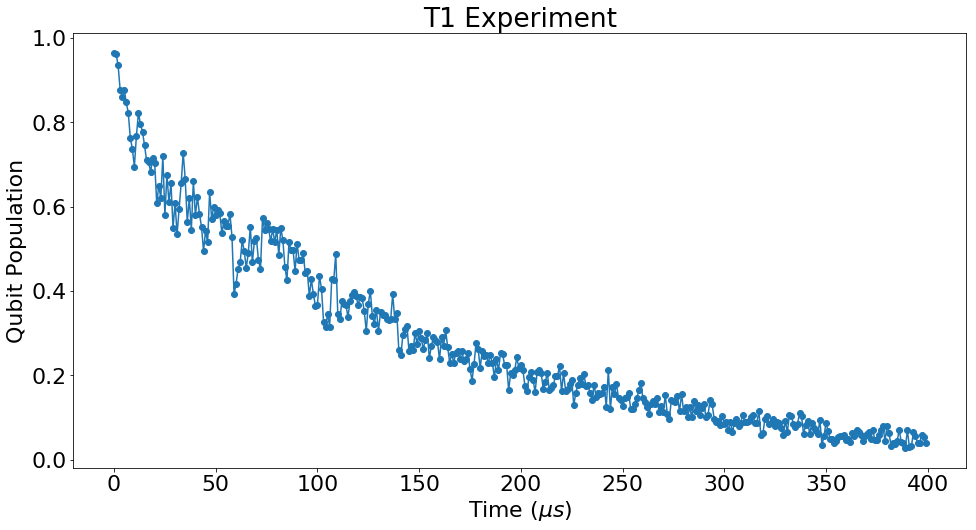

In [16]:
expt_cfg={ "start":0, "step":1, "expts":400, "reps": 400,
        "relax_delay":750
       }
config={**hw_cfg,**readout_cfg,**qubit_cfg,**expt_cfg} #combine configs

t1p=T1Program(cfg=config)

x_pts, avgi, avgq = t1p.acquire(soc, threshold=readout_cfg["threshold"], load_pulses=True, progress=True, debug=False)
subplot(111, title="T1 Experiment", xlabel=f"Time ($\mu s$)", ylabel="Qubit Population")
plot(x_pts, avgi[0][0],'o-');

# Ramsey Fringe Experiment

Measures the qubit T2 Ramsey characteristic decay time by preparing the qubit in a superposition state with a  $\frac{\pi}{2}$ pulse followed by a variable delay ($\tau$) before applying another $\frac{\pi}{2}$ pulse with a phase advanced by $\Delta \phi = \omega * \tau$, where $\omega$ is the Ramsey frequency. This exponential decay envelope can be fitted in post-processing to obtain the qubit T2 Ramsey time.

In [17]:
class RamseyProgram(RAveragerProgram):
    def __init__(self,cfg):
        AveragerProgram.__init__(self,cfg)       
        
    def initialize(self):
        cfg=self.cfg
        
        self.q_rp=self.ch_page(self.cfg["qubit_ch"])     # get register page for qubit_ch
        self.r_wait = 3
        self.r_phase2 = 4
        self.r_phase=self.sreg(cfg["qubit_ch"], "phase")
        self.regwi(self.q_rp, self.r_wait, cfg["start"])
        self.regwi(self.q_rp, self.r_phase2, 0)
        
        f_res=freq2reg(adcfreq(cfg["f_res"]))            # conver f_res to dac register value
        f_ge=freq2reg(cfg["f_ge"])
        
        self.cfg["adc_lengths"]=[self.cfg["readout_length"]]*2   #copy over adc acquisition parameters
        self.cfg["adc_freqs"]=[adcfreq(cfg["f_res"])]*2
        
        # add qubit and readout pulses to respective channels
        self.add_pulse(ch=self.cfg["qubit_ch"], name="qubit", style="arb", idata=gauss(mu=cfg["sigma"]*16*4/2,si=cfg["sigma"]*16, length=4*cfg["sigma"]*16, maxv=2**15-1))
        self.add_pulse(ch=self.cfg["res_ch"], name="measure", style="const", length=self.cfg["readout_length"])
               
        # pre-initialize pulses
        self.pulse(ch=cfg["qubit_ch"], name="qubit", phase=0, freq=f_ge, gain=cfg["pi2_gain"], play=False)
        self.pulse(ch=cfg["res_ch"], name="measure", freq=f_res, phase=cfg['res_phase'], gain=cfg["res_gain"], play=False)
    
        self.sync_all(us2cycles(0.2))
    
    def body(self):
        
        self.pulse(ch=self.cfg["qubit_ch"],phase=0, play=True)  #play probe pulse
        self.mathi(self.q_rp, self.r_phase, self.r_phase2,"+",0)
        self.sync_all()
        self.sync(self.q_rp,self.r_wait)
        self.pulse(ch=self.cfg["qubit_ch"], play=True)  #play probe pulse
        self.sync_all(us2cycles(0.05))
        self.trigger_adc(adc1=1, adc2=1, adc_trig_offset=self.cfg["adc_trig_offset"])  #trigger measurement
        self.pulse(ch=self.cfg["res_ch"], name="measure", play=True) # play measurement pulse
        self.sync_all(us2cycles(self.cfg["relax_delay"]))  # wait for qubit to relax
    
    def update(self):
        self.mathi(self.q_rp, self.r_wait, self.r_wait, '+', self.cfg["step"]) # update the time between two π/2 pulses
        self.mathi(self.q_rp, self.r_phase2, self.r_phase2, '+', self.cfg["phase_step"]) # advance the phase of the LO for the second π/2 pulse

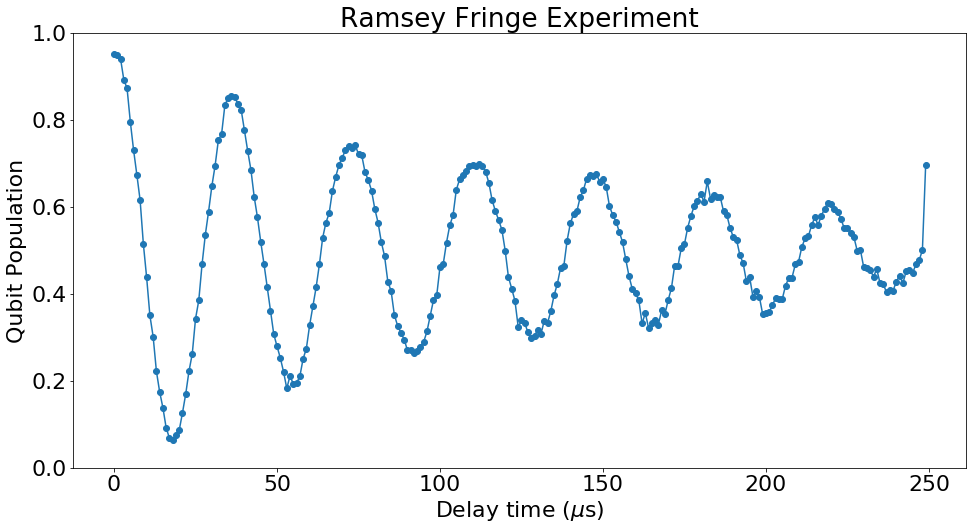

In [18]:
expt_cfg={"start":us2cycles(0.0), "step":us2cycles(1), "phase_step": deg2reg(2*360/100), "expts":250,
          "reps": 10, "rounds": 200
       }
config={**hw_cfg,**readout_cfg,**qubit_cfg,**expt_cfg} #combine configs
t2p=RamseyProgram(cfg=config)
x_pts, avgi, avgq= t2p.acquire(soc, threshold=readout_cfg["threshold"], load_pulses=True,progress=True, debug=False)

subplot(111, title="Ramsey Fringe Experiment", xlabel="Delay time ($\mu$s)", ylabel="Qubit Population")
plot(cycles2us(x_pts),avgi[0][0],'o-')
ylim(0,1);